<a href="https://colab.research.google.com/github/danbernstein/parkingdirty/blob/master/keras_visualize_heatmap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Modules

In [0]:
# load modules
import os # for accessing project file structure
import requests # for downloading and loading data from the internet
import zipfile # for unzipping zip files 

import numpy.random 
from matplotlib import pyplot # for plotting results

# build CNN using tf.keras
from keras import models # for building CNN (deep learning)
from keras import layers # for building fully connected network
from keras import losses
from keras import optimizers

# Data Set-Up

1) Define the problem at hand and the data you will be training on; collect this data or
annotate it with labels if need be.

**Define the problem:** the process of classifying whether a bikelane is blocked or not is currently manual and time-consuming. Accurately classifying traffic camera images of bikelanes could be accelerated through automatic methods.

**What data is available:** traffic camera data from Arlington, VA county intersections with bikelanes, available at http://parkingdirty.com/ 

**Trying to predict:** binary classification of whether or not a bikelane is blocked in a given image.

**Data labeling:** The need for more data labeling will be assessed at the end of the project by how well the deep learning model is able to classify the data. 

2) Choose how you will measure success on your problem. Which metrics will you be
monitoring on your validation data?

I will be monitoring the binary classification accuracy on the validation data. However, I will have to monitor the ratio of the loss function between the training and validation data to avoid overfitting. 

## Download and Extract Data

The data is stored as a zip file online. There are numerous modules that allow you to connect to, download, and unzip zip files, however the below approach is the easiest one I have found.

In [0]:
# download and read in data
zip_address = 'http://parkingdirty.com/BlockedBikeLaneTrainingFull.zip'

import requests, zipfile, io
r = requests.get(zip_address)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall() 

The extracted data resides in multiple sub-directories. The two important ones are "blocked" and "notblocked", which contain images labeled as containing a blocked bikelane or not, respectively. 


Next, I assign the two sub-directories to lists and add the label ("blocked" or "notblocked") to the file path. Then I shuffle the data so no sequential patterns continue once the data is split into training and test data.

## Data Processing (Organizing, Labeling, and Splitting)

In [4]:
# append the label at front, and assign to object
imgs_blocked = list(map('blocked/{0}'.format, os.listdir('blocked')))
imgs_notblocked = list(map('notblocked/{0}'.format, os.listdir('notblocked')))

# shuffle data
numpy.random.shuffle(imgs_blocked)
numpy.random.shuffle(imgs_notblocked)

print("number of blocked images: ", len(imgs_blocked))
print("number of not blocked images: ", len(imgs_notblocked))
print("ratio of classes: ", len(imgs_blocked)/len(imgs_notblocked))

number of blocked images:  4180
number of not blocked images:  3968
ratio of classes:  1.0534274193548387


In [5]:
# check that there are no duplicates between the two datasets
all_imgs = imgs_blocked + imgs_notblocked 

set([x for x in all_imgs if all_imgs.count(x) > 1])


set()

Next I take 80% of both the blocked and not blocked images and assign them to a training dataset, while the other 20% is assigned to test model outputs.


In [6]:
# separate into training (contains training and validation), and test set
training_set = imgs_blocked[:int(round(0.8*len(imgs_blocked)))] + imgs_notblocked[:int(round(0.8*len(imgs_notblocked)))]
print(len(training_set))

test_set = imgs_blocked[int(round(0.8*len(imgs_blocked))):] + imgs_notblocked[int(round(0.8*len(imgs_notblocked))):]
print(len(test_set))

del imgs_blocked
del imgs_notblocked

6518
1630


## Image Processing and Resizing

The cv2 package brings together the most common tools for working with image data. Here, I create two lists, one for the images (represented as mathematical arrays, here called "img_arrays") and another for the image labels taken from the file paths. The ```read_resize_label_image``` function takes each image file, reads it (```imread```), then resizes it based on parameters for the x and y dimensions (```resize```) and interpolates in the new dimensions. This information is added to the img_arrays list. The file path is then parsed, if the word "not" appears in the file path, the value of ```img_labels``` is 0, if not, the value is 1. These two lists give the X and Y data. 

In [0]:
# read and resize images, also store as X, Y with X as image array and Y as label
import cv2

img_arrays = [] # images
img_labels = [] # labels

def read_resize_label_image(img, x_dim, y_dim):
    
  img_orig = cv2.imread(img)
  img_arrays = cv2.resize(img_orig, dsize=(x_dim, y_dim), interpolation=cv2.INTER_CUBIC)
  
 # if the image file name contains "not" then assigned 0, otherwise 1, so 1 is blocked, 0 is notblocked
  if img.find("not") is not -1:
      img_labels = 0
  else:
      img_labels = 1
      
  del img_orig
   
    
  return img_arrays, img_labels


Next, we apply the new function to the training data, producing an array of the training images to serve as the predictors and then training_labels as the output values. 

In [0]:
training_arrays, training_labels = zip(*[(read_resize_label_image(i, 150, 150)) for i in training_set])

del training_set

In [0]:
test_arrays, test_labels = zip(*[(read_resize_label_image(i, 150, 150)) for i in test_set])

del test_set

In [10]:
import pandas
print("training: ", pandas.Series(training_labels).value_counts())
print("test: ", pandas.Series(test_labels).value_counts())


training:  1    3344
0    3174
dtype: int64
test:  1    836
0    794
dtype: int64


We can test that this worked by plotting the image. We can see from the image dimensions that the resize worked and the images are not 150x150. 


1


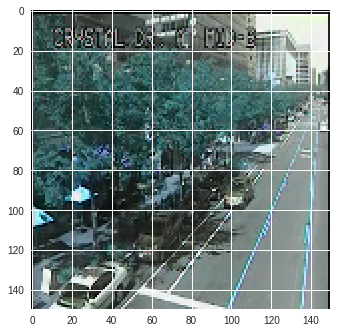

In [11]:
# show image
img_index = 330
print(training_labels[img_index])
pyplot.imshow(training_arrays[img_index])

## **Very Crucial Step: Converting X and Y to arrays**

In [0]:
import numpy as np

X_train_array = np.array(training_arrays)
Y_train_labels = np.array(training_labels)

del training_arrays
del training_labels

X_test_array = np.array(test_arrays)
Y_test_labels = np.array(test_labels)

del test_arrays
del test_labels

## Create Validation Set

**3) Determine your evaluation protocol: hold-out validation? K-fold validation? Which
portion of the data should you use for validation?**

The data will first be split into training and test, with 80% going to training and 20% in test. Then the trianing data will be split between training and validation, again 80% training and 20% validation. Shuffling the data is critical to ensuring the three datasets are representative. This evaluation protocol is hold-out, rather than K-fold, though that might be used at a later point for comparison's sake. 

As we move closer to building the model, we need to also create a dataset to tune the model parameters before the fully trained model is tested against outside data. For this reason, I will split the training data into train and test sets. In this context, the test data is the validation data, rather than the test_set created earlier, which will not be used in model creation, only afterwards. 80% of the data is now in the training data, and 20% in validation. 

In [13]:
# separate training data into training and validation sets

from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X_train_array, Y_train_labels, test_size = 0.2, 
                                                   shuffle = True)

# confirm the size of the datasets
print("training images: ", len(X_train))
print("training labels: ", len(Y_train))
print("validation images: ", len(X_test))
print("validation labels: ", len(Y_test))

training images:  5214
training labels:  5214
validation images:  1304
validation labels:  1304


#  Basic Model

**4) Develop a first model that does better than a basic baseline: a model that has
"statistical power".**

The basic baseline in this case would need be better than simply guessing that the bikelane is blocked 100% of the time, because the majority of the data points are blocked. This is 54.3%. 

**5) Develop a model that overfits.**
In this situation, developing a basic model to beat the baseline will also overfit the data. 

In [14]:
print("training: ", pandas.Series(Y_train).value_counts(1))
print("test: ", pandas.Series(Y_test).value_counts(1))

training:  1    0.511891
0    0.488109
dtype: float64
test:  1    0.517638
0    0.482362
dtype: float64


In [0]:
from keras import preprocessing

train_datagen_basic = preprocessing.image.ImageDataGenerator(
                                    rescale=1./255   #Scale the image between 0 and 1
                                    )

val_datagen_basic = preprocessing.image.ImageDataGenerator(rescale=1./255)  #We do not augment validation data. we only perform rescale

In [0]:
#Create the image generators
train_generator_basic = train_datagen_basic.flow(X_train, Y_train, batch_size=64)

val_generator_basic = val_datagen_basic.flow(X_test, Y_test, batch_size=64)

In [0]:
# basic model 
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))  #Sigmoid function at the end because we have just two classes

## Compiler Includes Optimizer, and Learning Rate (LR), and Metrics

model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=1e-4), metrics=['acc'])

In [18]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 15, 128)       147584    
__________

## Run the Basic Model

WIth the model compiled, we can run the basic model, which does not include any data augmentation or other potential improvements, beyond rescaling the pixle values to (0,1). To run the model, we set the number of epochs to 100, which indicates how many times to run through the data before finishing. 100 is picked arbitrarily, but is long enough to allow the model to go to overfitting in most cases.

In [19]:
batch_size = 64
epochs = 20

history_basic = model.fit_generator(train_datagen_basic.flow(X_train, Y_train, batch_size=64),
                                    validation_data = val_datagen_basic.flow(X_test, Y_test, batch_size=64),
                                    steps_per_epoch = X_train.shape[0] // batch_size,
                                    validation_steps = X_test.shape[0] // batch_size,
                                    epochs = epochs)

Epoch 1/20
81/81 [==============================] - 12s 142ms/step - loss: 0.6744 - acc: 0.5841 - val_loss: 0.6582 - val_acc: 0.6008
Epoch 2/20
81/81 [==============================] - 9s 112ms/step - loss: 0.6413 - acc: 0.6449 - val_loss: 0.6280 - val_acc: 0.6306
Epoch 3/20
81/81 [==============================] - 9s 107ms/step - loss: 0.6057 - acc: 0.6740 - val_loss: 0.6069 - val_acc: 0.6919
Epoch 4/20
81/81 [==============================] - 9s 107ms/step - loss: 0.5775 - acc: 0.6949 - val_loss: 0.5791 - val_acc: 0.7000
Epoch 5/20
81/81 [==============================] - 9s 108ms/step - loss: 0.5540 - acc: 0.7138 - val_loss: 0.6291 - val_acc: 0.6839
Epoch 6/20
81/81 [==============================] - 9s 107ms/step - loss: 0.5418 - acc: 0.7201 - val_loss: 0.5464 - val_acc: 0.7040
Epoch 7/20
81/81 [==============================] - 9s 108ms/step - loss: 0.5197 - acc: 0.7394 - val_loss: 0.5249 - val_acc: 0.7508
Epoch 8/20
81/81 [==============================] - 9s 109ms/step - loss: 0

In [0]:
#history_basic.__dict__

## Model Diagnostics

Test loss: 3.7891259808984348
Test accuracy: 0.7595092020883151


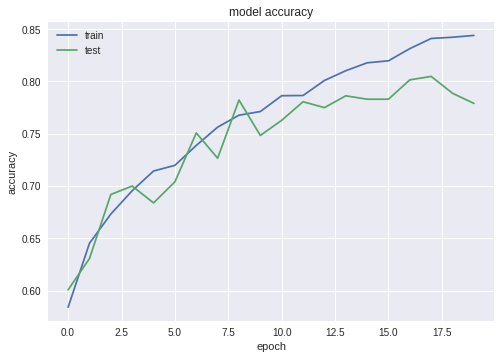

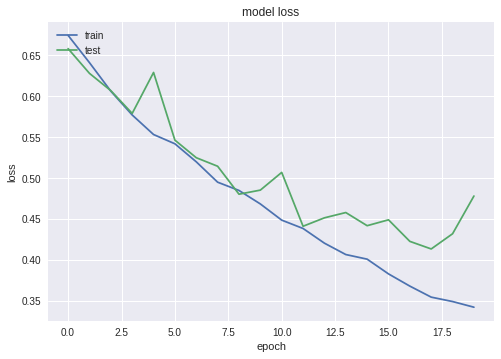

In [21]:
# evaluate model performance

score_basic = model.evaluate(X_test_array, Y_test_labels, verbose=0)
print('Test loss:', score_basic[0])
print('Test accuracy:', score_basic[1])

pyplot.plot(history_basic.history['acc'])
pyplot.plot(history_basic.history['val_acc'])
#pyplot.plot(history_basic.history['test_acc'])
pyplot.title('model accuracy')
pyplot.ylabel('accuracy')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'test'], loc='upper left')
pyplot.show()

# there is a large gap (0.18) btw training and validation accuracy, so it is probably overfitting the training data


pyplot.plot(history_basic.history['loss'])
pyplot.plot(history_basic.history['val_loss'])
#pyplot.plot(history_basic.history['test_acc'])
pyplot.title('model loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'test'], loc='upper left')
pyplot.show()


In [0]:
model.save('basic.h5')


In [0]:
import numpy as np
import matplotlib.pyplot as plt
from keras import backend as K
from keras.datasets import mnist
from keras.utils import np_utils
from vis.utils import utils
from keras.models import Model
from keras.layers import Conv2D, Dropout, Flatten, Dense, Input
# from vis.utils import utils
from vis.visualization import visualize_cam, visualize_activation, overlay, visualize_saliency

In [24]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 15, 128)       147584    
__________

The basic model shows overfitting after about 10-15 epochs. The options from here are either to limit modeling to 10-15 epochs to prevent overfitting, or to address overfitting with other methods, such as regularization. This basic model shows about 75-80% validation accuracy before overfitting, which is better than the baseline, so deep learning might be suitable for this task. 

# Visualizing what the computer "sees"

## visualize the features of the last convolutional layer picks up in feature extraction

In [0]:
def visualize_cam_heatmap(model, layer, index_val):
  
  from keras import backend as K
  import numpy as np
  
  index = index_val
  img = X_train[index] / 255

  layer_idx = utils.find_layer_idx(model, layer)

  #x = np.expand_dims(X_train[index] / 255, axis=0)

  heatmap = visualize_cam(model, layer_idx, filter_indices = 0, seed_input = img)

  # first plot the base img
  plt.imshow(img)    

  # add gradient as overlay
  plt.imshow(heatmap,cmap='jet', alpha = 0.4)
  plt.title('CAM'+ '(img_index=' + str(index) + ')')
  plt.savefig('./heatmap_' + str(index) + '.jpg')
  
  
def visualize_saliency_heatmap(model, layer, index_val):
  
  from keras import backend as K
  import numpy as np
  
  index = index_val
  layer_idx = utils.find_layer_idx(model, layer)
 # print(layer_idx)
  
  img = X_train[index] / 255

  #x = np.expand_dims(X_train[index] / 255, axis=0)

  heatmap = visualize_saliency(model, layer_idx, filter_indices = 0, seed_input = img)
  
  # first plot the base img
  plt.imshow(img)

  # add gradient as overlay
  plt.imshow(heatmap,cmap='jet', alpha = 0.4)
  plt.title('saliency'+ '(img_index=' + str(index) + ')')
  

def visualize_heatmaps(model, last_conv, last_dense, index_val):
  plt.subplot(1, 2, 1)
  visualize_saliency_heatmap(model,last_dense, index_val)
  plt.subplot(1, 2, 2)
  visualize_cam_heatmap(model,last_conv, index_val)
  plt.savefig('./heatmaps_' + str(index_val) + ".jpg")



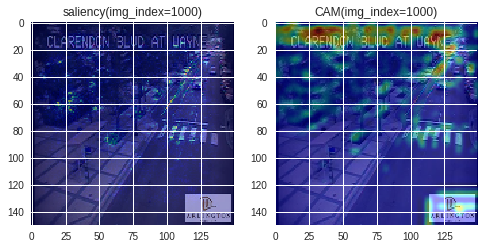

In [31]:
visualize_heatmaps(model, 'conv2d_4', 'dense_2', 1000)

In [0]:
#!pip uninstall keras-vis
#!pip install git+https://github.com/raghakot/keras-vis.git -U